# Introduction
This notebook generates the figures for the paper: Sensitivity Analysis of Biochemical Systems Using
Bond Graphs - Pentose Phosphate Pathway Example


# Set up the code

## Import packages

In [1]:
## Some useful imports
import BondGraphTools as bgt
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import control as con
import copy
import importlib
import time

## For reimporting: use imp.reload(module)
import importlib as imp

# ## For path etc: sys.path
import sys
sys.path.append("/home/peterg/WORK/Research/SystemsBiology/lib/python")

# 
## Stoichiometric analysis
import stoich as st

## SVG
import svgBondGraph as sbg

## Stoichiometry to BG
import stoichBondGraph as stbg

## Sloppy parameters
import sloppy as slp

## Display (eg disp.SVG(), disp.
import IPython.display as disp

##
quiet = True
Plotting = False
Titles = True

Warning - scikit.odes not found. Simulations are disabled.


In [2]:
def tfProps(tf,method='truncate'):
    
    ## Steady-state gain 
    g = con.dcgain(tf)
    
    if not con.issiso(tf):
        g = g[0][0]
    
    ## Time constant
    ## Check if direct link
    direct_link = np.any(tf.D)
    ## Only set tau=0 if siso
    if direct_link and con.issiso(tf):
        ## Instant response
        tau = 0
    else:       
        ## Reduce to first-order to estimate time constant
        ## Note that method='matchdc' can give a kernel crash - use 'truncate'
        tf1  = con.balred(sys,orders=1,method=method)
        poles = con.poles(tf1)
        realPoles = np.real(poles)
        tau = -1/min(realPoles)
        
    return g,tau

In [3]:
## High frequency gain function (initial response to step)
def hfgain(sys):
    
    tf = con.ss2tf(sys)
    num = tf.num[0][0]
    den = tf.den[0][0]
    n = len(den)
    m = len(num)
#     print(den)
#     print(num)
#     print(n,m)
    
    if n==m:
        g = num[0]/den[0]
    elif n>m:
        g = 0
    elif n<m:
        g = float('inf')
        
    return g
        
    
# g = hfgain(sys)
# print(g)

In [4]:
## Optional plotting
def Savefig(name):
    if Plotting:
        plotname = 'Figs/'+name+'.pdf'
        print('Saving',plotname)
        plt.rcParams.update({'font.size': 20})
        plt.tight_layout()
        plt.savefig(plotname)
        plt.clf()

## Steady-state by simulation

In [5]:
## Steady-state by simulation
def SteadyState(s,sc,sf=None,parameter={},X0=None,t_ss=1000):
    t = np.linspace(0,t_ss)
    dat = st.sim(s,sc=sc,sf=sf,t=t,parameter=parameter,X0=X0,tol=1e-4,quiet=quiet)
    X_ss = dat['X'][-1]
    V_ss = dat['V'][-1]
    #dX_ss = sc['N']@V_ss
    dX_ss = dat['dX'][-1]
    dXc_ss = dat['dXc'][-1]
    print(f'Steady-state finder error: {np.linalg.norm(dXc_ss):.2e}')
    return X_ss,V_ss


## Stoichiometry

In [6]:
def Stoichiometry(model,chemostats=[],flowstats=[],CommonSpecies=None,sensitivity=False):
    
    ## Stoichiometry
    s = st.stoich(model,quiet=quiet)

    ## Unify species
    if not (CommonSpecies is None):
        commonSpecies = st.merge(s,CommonSpecies=CommonSpecies)
#         print(commonSpecies)
        st.unify(s,commonSpecies=commonSpecies)
        
    ## Sensitivity
    if sensitivity:
        extra = st.stoichSensitivity(s)
    else:
        extra = []
    
#     print(chemostats+extra)

    ## Chemostats and flowstats
    sc = st.statify(s,chemostats=chemostats+extra)
    sf = st.statify(s,flowstats=flowstats)
        
    return s,sc,sf

## Linearisation

In [7]:
def Linear(s,sc,sf=None,parameter={},X0=None, invar='X', outvar = 'V', quiet=False):
    
    ## Steady state
    if X0 is None:
        X0 = np.ones(s['n_X'])
#     print(len(X0))

    X_ss,V_ss = SteadyState(s,sc,sf=sf,parameter=parameter,X0=X0)
    dX_ss = s['N']@V_ss
#     print('X_ss =',X_ss)
    print('V_ss =', V_ss)
#     print('dX_ss =', dX_ss)
        
    ## Linearise
    sys = st.lin(s,sc,sf=sf,x_ss=X_ss,parameter=parameter,
                 invar=invar,outvar=outvar,quiet=quiet)
    
    return sys,X_ss,V_ss,dX_ss
  


## Extract subsystem from linear system

In [8]:
def Index(A,a):
    
    I = []
    for aa in a:
        i = A.index(aa)
        I.append(i)
    return np.array(I)
        
def zapSmall(x,tol=1e-10,quiet=True):
    
    xx = np.zeros(len(x))
    for i,val in enumerate(x):
        if abs(val)>tol:
            xx[i] = x[i]
        else:
            if not quiet:
                print(f'Setting {i}th coefficient {val:.2} to zero')
    return xx

def extractSubsystem(SYS,sc,sf,inp,outp,tol=1e-3,order=None,minreal=False,quiet=False):
    
    Sys = copy.copy(SYS)
    chemostats = sc['chemostats']
    if sf is None:
        flowstats = []
    else:
        flowstats = sf['flowstats']
    species = sc['species']
    reaction = sc['reaction']
    
    ## Index of input and output
    if inp[0] in chemostats:
        i_inp = Index(chemostats,inp)
#         print('Input:',i_inp,chemostats[i_inp[0]])
    else:
        i_inp = Index(flowstats,inp)+len(chemostats)
        
#     print(i_inp)
    
    if outp[0] in chemostats:
#         i_outp = Index(chemostats,outp)
        i_outp = Index(species,outp)
    elif outp[0] in species:
        i_outp = Index(species,outp)
    else:
        if outp[0] in reaction:
            i_outp = Index(reaction,outp)
        else:
            print(f'Output {outp} does not exist')
 
    ## Extract tf
    n_y = len(i_outp)
    n_u = len(i_inp)
    nn = Sys.A.shape
    n_x = nn[0]
    #print(n_x)
    
    sys = con.ss(Sys.A,
                 Sys.B[:,i_inp].reshape(n_x,n_u),
                 Sys.C[i_outp,:].reshape(n_y,n_x),
                 Sys.D[i_outp][:,i_inp].reshape(n_y,n_u))
    
    if minreal:
        sys = con.minreal(sys,tol=tol,verbose=True)
    
    ## Reduce order
    if not (order is None):
        sys = con.balred(sys,order,method='matchdc')
    
    return sys

## Plotting

In [9]:
def plotSensitivity(dat,reactions=['r1','r2'],plotSim=True,name=None,labeling=True):
 
    if plotSim:
        plt.plot(t,y_step,color='black')
    else:
        plt.plot(t,y_step,label=label)  
        
    for reac in reactions:
        i = s['reaction'].index(reac)
        if plotSim:
#             label = reac + r' ($\tilde\lambda$ = ' + f'{lam-1:0.2f})'
            pc = int(round(100*(lam-1)))
            if labeling:
                label = f'{reac} ({pc}%)'
            else:
                label = None
            plt.plot(t,(dat['V'][:,i]-V_ss[i])/(lam-1),
                     lw=5,ls='dashed',label=label)

    plt.grid()
    if labeling:
        plt.legend()
    plt.xlabel('$t$')
    plt.ylabel(r'$\tilde{v}/\tilde{\lambda}$')
#     plt.ylim(bottom=0)
#     plt.xlim(left=0)
#     plt.tight_layout()
    

In [10]:
def plotSensitivitydX(dat,species=['A','C'],plotSim=True,name=None,labeling=True,setZero=False):
    if plotSim:
        plt.plot(t,y_step,color='black')
    else:
        plt.plot(t,y_step,label=label)  
        
    for spec in species:
        print(spec)
        i_s = s['species'].index(spec)
        if plotSim:
            pc = int(round(100*(lam-1)))
            if labeling:
                label = f'{spec} ({pc}%)'
            else:
                label=None
            plt.plot(t,(dat['dX'][:,i_s]-dX_ss[i_s])/(lam-1),
                     lw=5,ls='dashed',label=label)

    plt.grid()
    if labeling:
        plt.legend()
    plt.xlabel('$t$')
    plt.ylabel(r'$\Delta \mathbf{f} /\Delta \lambda$')
    #plt.ylabel(r'$\tilde{\dot{x}}/\tilde{\lambda}$')
    if setZero:
        plt.ylim(bottom=0)
        plt.xlim(left=0)
#     plt.tight_layout()
    

In [11]:
def plotLines(lw=4,ls='dotted'):
        plt.hlines(g,min(t),max(t),color='black',ls=ls,lw=lw)
        plt.vlines(tau,min(y_step.flatten()),1.1*max(y_step.flatten()),color='black',ls=ls,lw=lw)

# Normalisation constants

In [12]:
T_human = 37 # Human body temperature
K_0 = 273.15
print(f'T_human = {T_human} degC = {T_human+K_0} K')

mu_0 = RT = st.RT(T_cent=T_human)
print(f'mu_0 = {mu_0*1e-3:0.3f} kJ/mol')

F = st.F() # Faraday's constant
print(f'F = {F*1e-3:0.2f} kC/mol')

V_0 = RT/F
print(f'V_0 = {V_0*1e3:0.2f} mV')

P_0 = 1e-3

v_0 = P_0/mu_0
print(f'v_0 = {v_0*1e6:0.4f} micro mol /s')

i_0 = F*v_0
print(f'i_0 = {i_0*1e3:0.2f} mA')

T_human = 37 degC = 310.15 K
mu_0 = 2.579 kJ/mol
F = 96.49 kC/mol
V_0 = 26.73 mV
v_0 = 0.3878 micro mol /s
i_0 = 37.42 mA


# Stoichiometric approach

In [13]:
def simSensitivity(s,sc,sf,Sys,X_ss,V_ss,dX_ss,chemostats=['A','C'],
                   inp=['sr1'],outp=['r1','r2'],t_last=2,parameter={},lam=1.2,order=None,tol=None):

    ## Extract sensitivity system
    sys = extractSubsystem(Sys,sc,sf,inp=inp,outp=outp,order=order,tol=tol)
    
    ## Time
    t = np.linspace(0,t_last,500)
    
    ## Sensitivity step response
    step = con.step_response(sys,T=t)
    y_step = step.y[:,0,:].T
    
    ## Exact simulation with changed parameter or state
    X_ss_1 = copy.copy(X_ss)
    parameter1 = copy.copy(parameter)
    inComp = inp[0][1:]
    
    if inComp in chemostats:
        ## Perturb state
        iComp = s['species'].index(inComp)
        X_ss_1[iComp] = lam*X_ss_1[iComp]
    else:
        ## Perturb parameter
        if inComp in s['species']:
            parname = 'K_'+inComp
        else:
            parname = 'kappa_'+inComp
     
        print(parname)
    
        if parname in list(parameter.keys()):
            parameter1[parname] = lam*parameter[parname]
        else:
            parameter1[parname] = lam
        
    dat = st.sim(s,sc=sc,sf=sf,t=t,parameter=parameter1,X0=X_ss_1,quiet=quiet)

    return dat,y_step,t,sys



# Import Pentose Phosphate Pathway information from:

Peter J. Gawthrop, Michael Pan, and Edmund J. Crampin. *Modular dynamic biomolecular modelling with bond graphs: the unification of stoichiometry, thermodynamics*,
kinetics and data. Journal of The Royal Society Interface, 18(181):20210478, 2021.
doi:10.1098/rsif.2021.0478.

In [14]:
## Load data
import pickle
filename = 'GlyPPP.pic'
datafile = open(filename, 'rb')
GlyPPP = pickle.load(datafile)

s0 = GlyPPP['s']

parameter = GlyPPP['parameter']
print(parameter)

sc0 = GlyPPP['sc']
chemostats = sc0['chemostats']
print(chemostats)

conc = GlyPPP['conc']

import json
print(json.dumps(parameter,indent=2))

{'kappa_PGI': 154.38997002578546, 'kappa_PFK': 54.85043355391926, 'kappa_FBA': 160.07691981318658, 'kappa_TPI': 353.9323765134668, 'kappa_G6PDH2R': 4.667672687418436, 'kappa_PGL': 291.6414393949941, 'kappa_GND': 1.2695594575280742, 'kappa_RPI': 4206.975085828208, 'kappa_TKT2': 9.170830408091838, 'kappa_TALA': 1.6563170906188465, 'kappa_TKT1': 8.819978413932159, 'kappa_RPE': 96.07053469867635, 'K_6PGC': 6.233520699319548, 'K_6PGL': 1.0397283862123778, 'K_ADP': 5.154605959675528, 'K_ATP': 2.2539233202427162, 'K_CO2': 33.794182951886775, 'K_DHAP': 1.778985981513151, 'K_E4P': 57.93534155565906, 'K_F6P': 1.41401983409913, 'K_FDP': 0.38795235349448437, 'K_G3P': 14.902044199279699, 'K_G6P': 0.8377378837717493, 'K_H': 0.3491739027654742, 'K_H2O': 1.0397283862123778, 'K_NADP': 11747.063287701598, 'K_NADPH': 21.002665768445333, 'K_R5P': 12.241945837528652, 'K_RU5PD': 86.15506601742248, 'K_S7P': 21.751324335743256, 'K_XU5PD': 51.68293204643235}
['ADP', 'ATP', 'CO2', 'G6P', 'H', 'H2O', 'NADP', 'NA

In [15]:
## Reactions
disp.Latex(st.sprintrl(s0,chemformula=True))

<IPython.core.display.Latex object>

In [16]:
## Pathway reactions
sp0 = st.path(s0,sc0)
disp.Latex(st.sprintrl(sp0,chemformula=True))

<IPython.core.display.Latex object>

## Repeat simulations for sanity check

In [17]:
def setPath(s,path='R5P'):
    
    print('\n Path =', path)
    
    if path == 'R5P':
        chemostats = ['ADP', 'ATP', 'CO2', 'G6P', 'H', 'H2O', 'NADP', 'NADPH', 'R5P']
        flowstats =['G6PDH2R']
        dX_G6P = 5
    elif path == 'NADPH':
        chemostats = ['ADP', 'ATP', 'CO2', 'G6P', 'H', 'H2O', 'NADP', 'NADPH']
        flowstats = []
        dX_G6P = 1
    elif path == 'both':
        chemostats = ['ADP', 'ATP', 'CO2', 'G6P', 'H', 'H2O', 'NADP', 'NADPH', 'R5P']
        flowstats =  ['PGI', 'TKT2']
        dX_G6P = 1
    elif path == 'all':
        chemostats = ['ADP', 'ATP', 'CO2', 'G6P', 'H', 'H2O', 'NADP', 'NADPH', 'R5P','G3P']
        flowstats = []
        dX_G6P = 10
    elif path == 'all_e4p':
        chemostats = ['ADP', 'ATP', 'CO2', 'G6P', 'H', 'H2O', 'NADP', 'NADPH', 'R5P','G3P','E4P']
        flowstats = []
        dX_G6P = 10
        
    sc = st.statify(s,chemostats=chemostats)
    sf = st.statify(s,flowstats=flowstats)
    
    return sc,sf,dX_G6P


In [18]:
## Data normalisation
c_0 = 7.88 # mM
f_0 = 0.9916666666666667 # mM/sec
t_0 = 7.946218487394957 # sec

In [19]:
## Simulate for each path
s = copy.copy(s0) ## for compatibility
spec = s['species']
approximateFlowstats = True

Spec = ['G6P','R5P','NADPH','ADP','CO2','H','H2O']
#paths = ['all','both','R5P','NADPH']
#paths = ['R5P']
#paths = ['all','both','NADPH','R5P']
paths = ['both','NADPH','R5P','all_e4p','all']
RATIO = {}
for path in paths:
    Ratio = {}
    normalisedRatio = {}
 
    ## Set up pathway
    sc,sf,dX_G6P_0 = setPath(s,path=path)
    
    ## Print pathway
    sp = st.path(s,sc)
    print(st.sprintrl(sp))
    
    ## Set up parameters
    par = copy.copy(parameter)
    if approximateFlowstats:
        small = 1e-3
        par = copy.copy(parameter)
        for fs in sf['flowstats']:
            par['kappa_'+fs] = small
        sf = None
        
    ## Simulate
    t = np.linspace(0,3*t_0,1000)
    
#     ## Find steady-state with no flowstats 
#     dat_ss = st.sim(s,sc=sc,sf=sf,t=t,parameter=parameter,X0=conc)
#     X_ss = dat_ss['X'][-1,:]
    
    dat = st.sim(s,sc=sc,sf=sf,t=t,parameter=par,X0=conc)
    #st.plot(s,dat,species=[])
#     st.plot(s,dat,reaction=[],species=Spec,dX=True)
    
    ## Extract some external flows
    DX = dat['dX']
    dX = {}
    for Sp in Spec:
        dX[Sp] = DX[:,spec.index(Sp)]
        Ratio[Sp] = -dX[Sp]/dX['G6P']
        normalisedRatio[Sp] =  -dX_G6P_0*dX[Sp]/dX['G6P'] 
        
    RATIO[path] = normalisedRatio
    
   
    ## Print steady-state values
    for Sp in Spec:
        ratio = Ratio[Sp][-1]
        print(f'{Sp}:\t{dX[Sp][0]:3.1f} \t{dX[Sp][-1]:3.1f}\t{(dX_G6P_0*ratio):3.1f}\t{100*ratio:3.1f}%')




 Path = both
\begin{align}
G6P + H2O + 2 NADP  &\Leftrightarrow CO2 + 2 H + 2 NADPH + R5P \\
ADP + 4 H2O + 8 NADP + 2 R5P  &\Leftrightarrow ATP + 4 CO2 + G6P + 7 H + 8 NADPH 
\end{align}

G6P:	-11.6 	-11.6	-1.0	-100.0%
R5P:	6.2 	11.5	1.0	99.4%
NADPH:	23.2 	23.2	2.0	200.0%
ADP:	63.1 	0.0	0.0	0.4%
CO2:	11.6 	11.6	1.0	100.0%
H:	86.3 	23.2	2.0	200.4%
H2O:	-11.6 	-11.6	-1.0	-100.0%

 Path = NADPH
\begin{align}
ADP + G6P + 6 H2O + 12 NADP  &\Leftrightarrow ATP + 6 CO2 + 11 H + 12 NADPH 
\end{align}

G6P:	-71.1 	-1.9	-1.0	-100.0%
R5P:	6.2 	0.0	0.0	0.0%
NADPH:	23.2 	23.1	12.0	1200.0%
ADP:	63.1 	-1.9	-1.0	-100.0%
CO2:	11.6 	11.6	6.0	600.0%
H:	86.3 	21.2	11.0	1100.0%
H2O:	-11.6 	-11.6	-6.0	-600.0%

 Path = R5P
\begin{align}
G6P + H2O + 2 NADP  &\Leftrightarrow CO2 + 2 H + 2 NADPH + R5P \\
ADP + 4 H2O + 8 NADP + 2 R5P  &\Leftrightarrow ATP + 4 CO2 + G6P + 7 H + 8 NADPH 
\end{align}

G6P:	-59.5 	-2.4	-5.0	-100.0%
R5P:	6.2 	2.9	6.0	120.0%
NADPH:	11.6 	0.0	0.0	0.2%
ADP:	63.1 	0.5	1.0	20.0%
CO2:	11.

In [20]:
## Set up chemostats to correspond to above path
chemostats = sc['chemostats']
Chemostats = copy.copy(sc['chemostats'])
print(path)
print(chemostats)

all
['ADP', 'ATP', 'CO2', 'G6P', 'H', 'H2O', 'NADP', 'NADPH', 'R5P', 'G3P']


In [21]:
## Plot ratios
plottingRatios = False
if plottingRatios:
    name = ['i','ii','iii']
    for sp in ['R5P','NADPH']: 
        BigFont = 24
        plt.rcParams.update({'font.size': BigFont})
        for i,path in enumerate(['both','R5P','NADPH']):
            Ratio = RATIO[path]
            label = f'Path {name[i]} ({path})'
            plt.plot(t/t_0,Ratio[sp],label=label,linewidth=5)
        if sp=='R5P':
            ylim = 8
        else:
            ylim=15
        plt.ylim((0,ylim))
        ylabel = r'$\rho_{'+sp+'}$'
        plt.ylabel(ylabel)
        plt.xlabel('$t/t_0$')
        plt.legend()
        plt.grid()
    #     if SaveFig:
    #         plt.savefig(f'Figs/{sp}.pdf',bbox_inches='tight')

        # plt.show()

# Sensitivity System

In [22]:
## Create sensitivity system
s = copy.copy(s0)
extra = st.stoichSensitivity(s)
chemostats += extra
sc = st.statify(s,chemostats=chemostats)

In [23]:
## Reactions
disp.Latex(st.sprintrl(s,all=True,chemformula=True))

<IPython.core.display.Latex object>

In [24]:
## Initial conditions
X0 = np.hstack((conc,np.ones(s0['n_X']),np.ones(s0['n_V'])))
# print(X0)
print(X0.shape)

(50,)


In [25]:
## Linearise
# Sys,X_ss,V_ss,dX_ss = Linear(s,sc,X0=X0)
# Sys,X_ss,V_ss,dX_ss = Linear(s,sc,parameter=parameter,X0=X0, invar='X', outvar = 'V', quiet=False)

In [26]:
# species = s['species']
# reaction = s['reaction']

In [27]:
# print(chemostats)
# print(reaction)
# print(species)
# # print(s0['Z'])

In [28]:
# sys = extractSubsystem(Sys,sc,sf,inp=['sG6P'],outp=['RPI'],order=3)

## Linearise sensitivity system

In [29]:
## Linearise dX as outvar
Sys,X_ss,V_ss,dX_ss = Linear(s,sc,parameter=parameter,X0=X0, invar='X', outvar = 'dX', quiet=False)

Steady-state finder error: 2.10e-14
V_ss = [59.52330023 63.11688312 63.11688312 63.11688312 11.57830405 11.57830405
 11.57830405  7.98472116  1.79679144  1.79679144  1.79679144  3.59358289]
Setting K_6PGC to 6.233520699319548
Setting K_6PGL to 1.0397283862123778
Setting K_ADP to 5.154605959675528
Setting K_ATP to 2.2539233202427162
Setting K_CO2 to 33.794182951886775
Setting K_DHAP to 1.778985981513151
Setting K_E4P to 57.93534155565906
Setting K_F6P to 1.41401983409913
Setting K_FDP to 0.38795235349448437
Setting K_G3P to 14.902044199279699
Setting K_G6P to 0.8377378837717493
Setting K_H to 0.3491739027654742
Setting K_H2O to 1.0397283862123778
Setting K_NADP to 11747.063287701598
Setting K_NADPH to 21.002665768445333
Setting K_R5P to 12.241945837528652
Setting K_RU5PD to 86.15506601742248
Setting K_S7P to 21.751324335743256
Setting K_XU5PD to 51.68293204643235
Setting kappa_PGI to 154.38997002578546
Setting kappa_PFK to 54.85043355391926
Setting kappa_FBA to 160.07691981318658
Settin

## Compute chemostat sensitivities

['sADP', 'sATP', 'sCO2', 'sG6P', 'sNADP', 'sNADPH', 'sR5P', 'sG3P']
Doing: sADP
g = 2.5484963469688147
dlam = 10
G6P


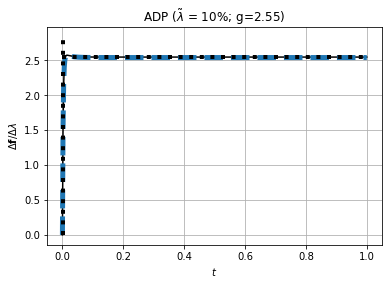

Doing: sATP
g = -33.46210603034223
dlam = 10
G6P


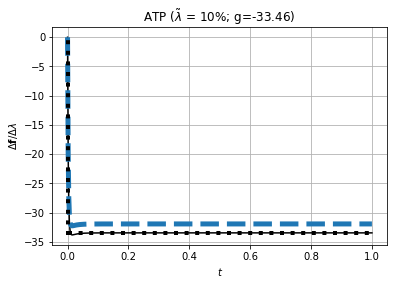

Doing: sCO2
g = 0.006924942429813596
dlam = 10
G6P


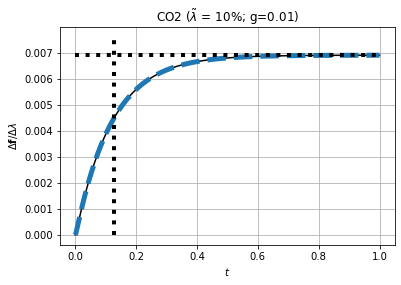

Doing: sG6P
g = -74.1814457534691
dlam = 10
G6P


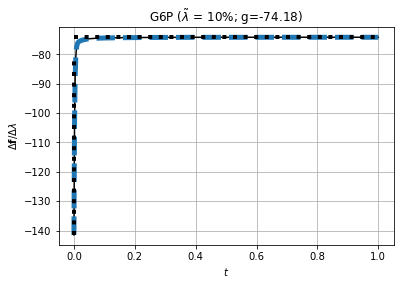

Doing: sNADP
g = -12.083105188911864
dlam = 10
G6P


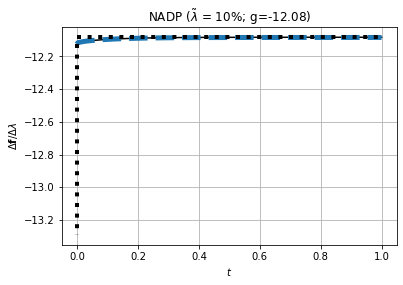

Doing: sNADPH
g = 0.5288892968979394
dlam = 10
G6P


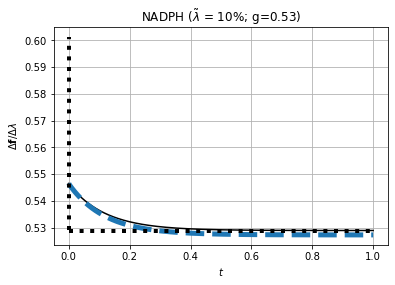

Doing: sR5P
g = 4.08711120268265
dlam = 10
G6P


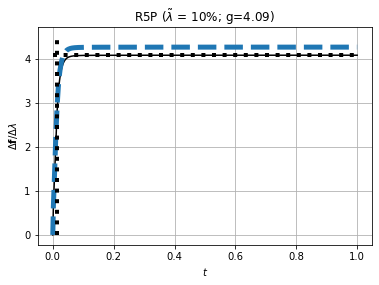

Doing: sG3P
g = 1.984521369029551
dlam = 10
G6P


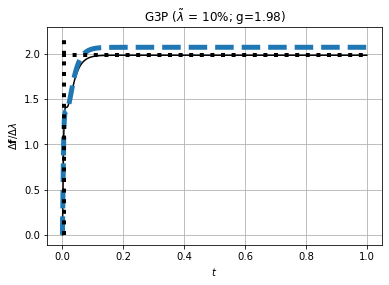

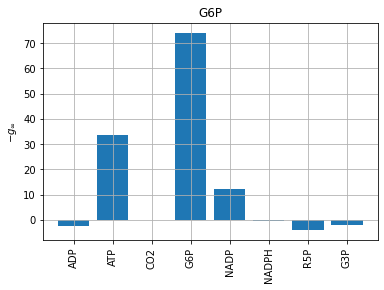

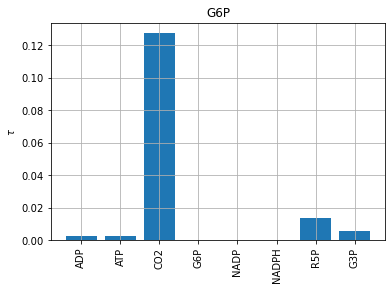

Doing: sADP
g = 0.0349248023890647
dlam = 10
R5P


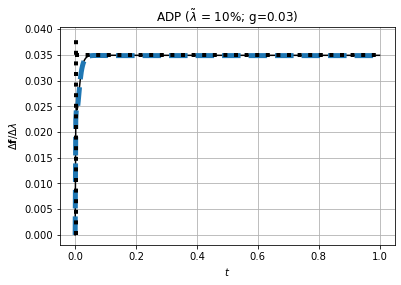

Doing: sATP
g = -0.4585674380195499
dlam = 10
R5P


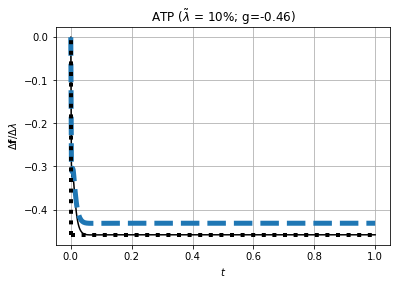

Doing: sCO2
g = -0.006919387119948707
dlam = 10
R5P


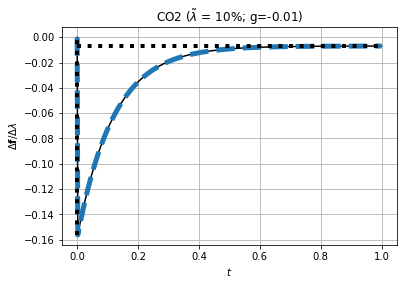

Doing: sG6P
g = 12.485591708850293
dlam = 10
R5P


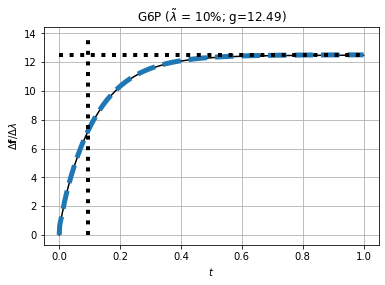

Doing: sNADP
g = 12.07341191065308
dlam = 10
R5P


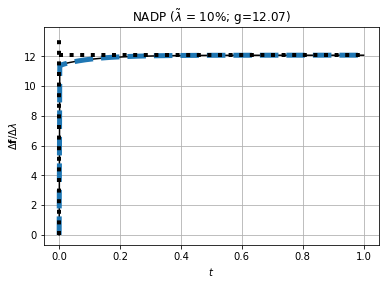

Doing: sNADPH
g = -0.5284650126561967
dlam = 10
R5P


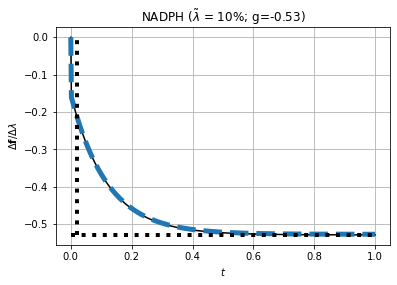

Doing: sR5P
g = -11.81229752462059
dlam = 10
R5P


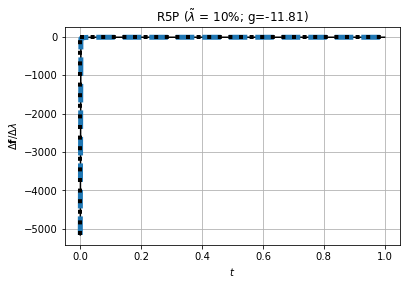

Doing: sG3P
g = 0.3634389561691993
dlam = 10
R5P


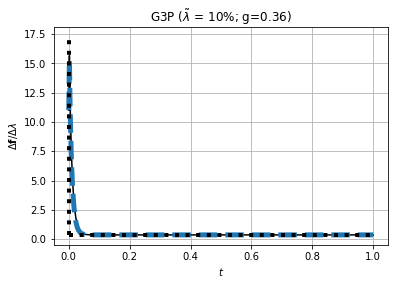

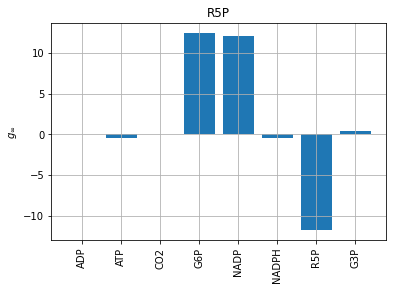

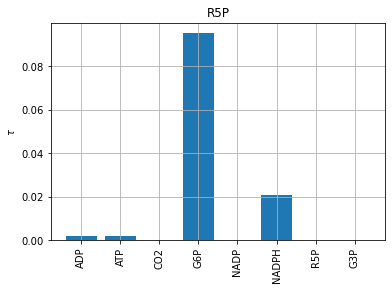

Doing: sADP
g = -6.262253882820029e-08
dlam = 10
NADPH


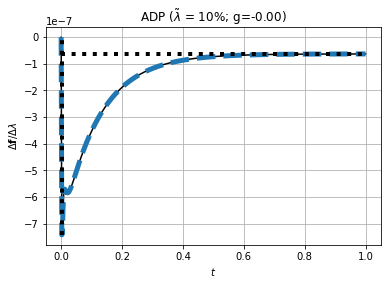

Doing: sATP
g = 8.22242510439288e-07
dlam = 10
NADPH


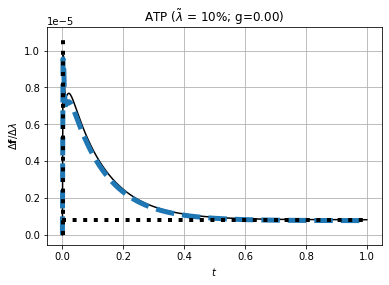

Doing: sCO2
g = -0.013855753145603666
dlam = 10
NADPH


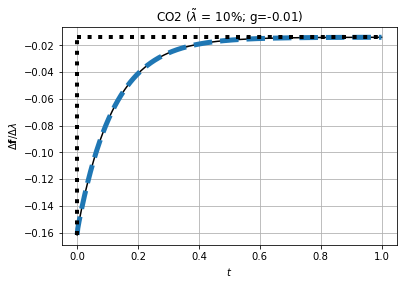

Doing: sG6P
g = 23.170431095483337
dlam = 10
NADPH


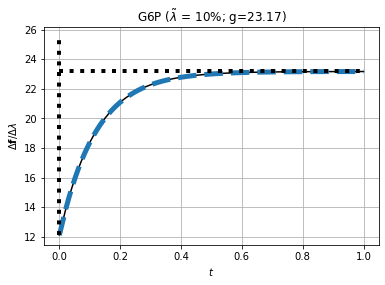

Doing: sNADP
g = 24.176449757783388
dlam = 10
NADPH


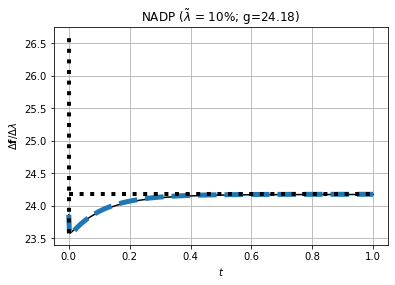

Doing: sNADPH
g = -1.058226781441594
dlam = 10
NADPH


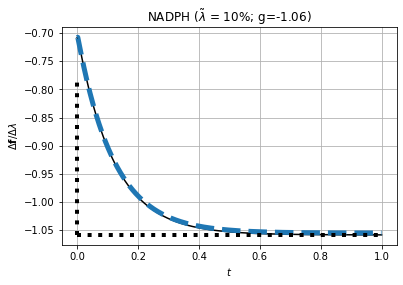

Doing: sR5P
g = -0.013813109583456041
dlam = 10
NADPH


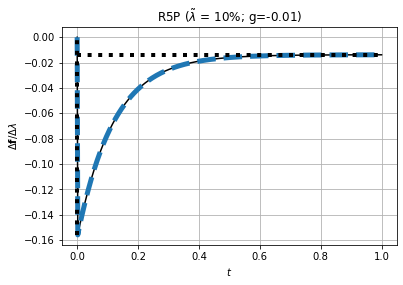

Doing: sG3P
g = -6.516705662261944e-07
dlam = 10
NADPH


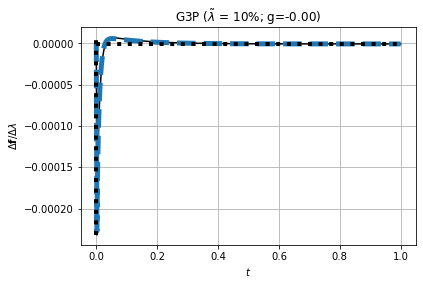

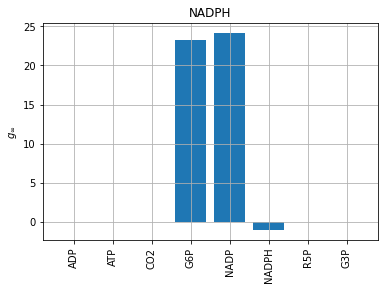

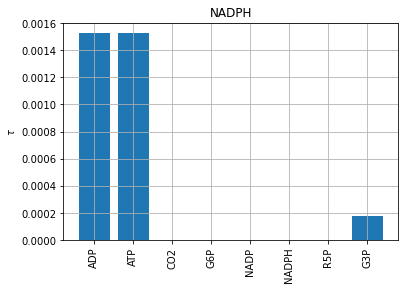

Doing: sADP
g = -5.155200687482189
dlam = 10
G3P


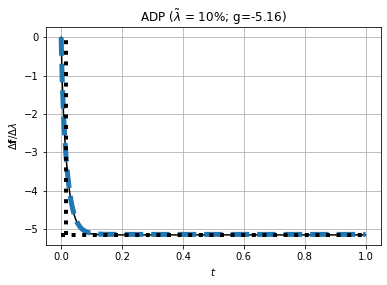

Doing: sATP
g = 67.68849098700832
dlam = 10
G3P


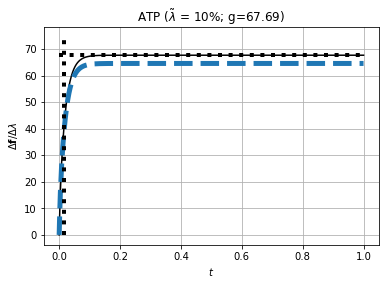

Doing: sCO2
g = -8.280802207064823e-06
dlam = 10
G3P


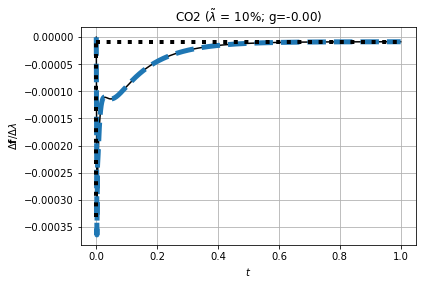

Doing: sG6P
g = 123.69183347627043
dlam = 10
G3P


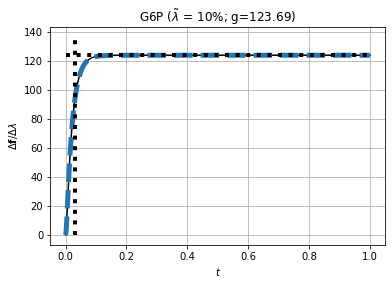

Doing: sNADP
g = 0.014448900437827383
dlam = 10
G3P


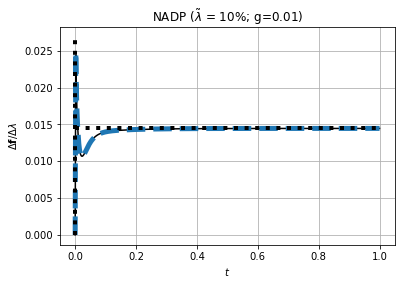

Doing: sNADPH
g = -0.0006324424618591407
dlam = 10
G3P


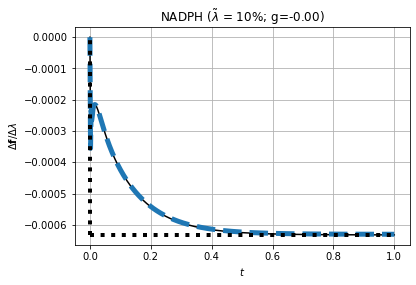

Doing: sR5P
g = 11.515242320596151
dlam = 10
G3P


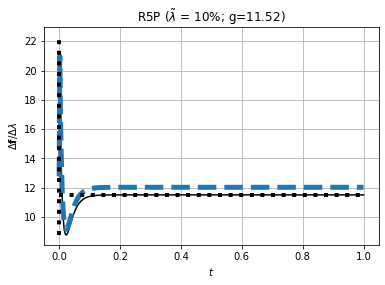

Doing: sG3P
g = -4.574774223072097
dlam = 10
G3P


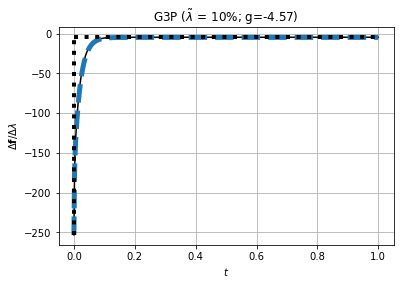

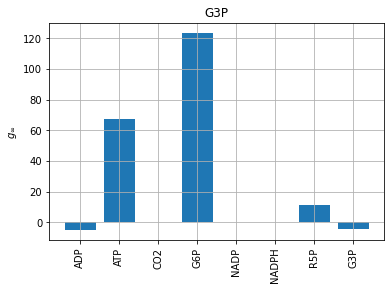

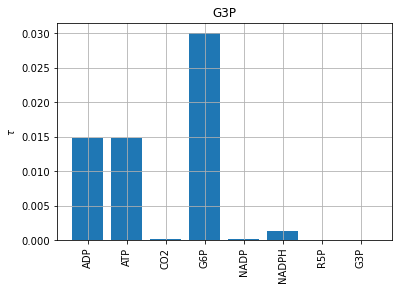

In [30]:
## Chemostat sensitivities
# Inp = ['sG6P','sR5P','sNADPH','sG3P']
Outp = ['G6P','R5P','NADPH','G3P']
Inp = []
for chemo in sc['chemostats']:
    if not chemo[0] in ['s','H']:
        Inp.append('s'+chemo)
print(Inp)
Inp_chemo = Inp
# Inp = []
# for reac in s['reaction']:
#     Inp.append('s'+reac)
# Inp = ['sG6PDH2R']

t_last=1
lam = 1.1 # Perturbation parameter

dcgain = {}
Tau = {}
for outp in Outp:
    for inp in Inp:
        print('Doing:',inp)
        sf = None
        order = None
        dat,y_step,t,sys = simSensitivity(s,sc,sf,Sys,X_ss,V_ss,dX_ss,chemostats=Chemostats,parameter=parameter,
                                      inp=[inp],outp=[outp],lam=lam,t_last=t_last,order=order)

        
        g = con.dcgain(sys)
        g,tau = tfProps(sys)
        print('g =',g)
        name = inp[1:]
        
        if outp=='G6P':
            dcgain[name] = -g
            ylabel = '$-g_{\infty}$'
        else:
            dcgain[name] = g
            ylabel = '$g_{\infty}$'
            
        Tau[name] = tau

        dlam = int((lam-1)*100)
        print('dlam =',dlam)
        if Titles:
            plt.title(f'{name}'+r' ($\tilde\lambda$ = ' + f'{dlam}%; g={g:.2f})')
        plotSensitivitydX(dat,species=[outp],labeling=False)
#         plt.hlines(g,min(t),max(t),color='black',ls='dashed')
        plotLines()
        Savefig('PPPdX_'+name+'_'+outp)
        plt.show()
        
    ## Barcharts
    ## DC gain
    if Titles:
        plt.title(outp)
    plt.tick_params(axis='x', rotation=90)
    plt.grid()
    plt.bar(range(len(dcgain)), dcgain.values(), align='center')
    plt.xticks(range(len(dcgain)), list(dcgain.keys()))
    plt.ylabel(ylabel)
    Savefig(f'PPPdX_{outp}_chem_bar')
    plt.show()
    
    ## Time constant
    if Titles:
        plt.title(outp)
    plt.tick_params(axis='x', rotation=90)
    plt.grid()
    plt.bar(range(len(Tau)), Tau.values(), align='center')
    plt.xticks(range(len(Tau)), list(Tau.keys()))
    plt.ylabel(r'$\tau$')
    Savefig(f'PPPdX_{outp}_chem_tau_bar')
    plt.show()

## Test model reduction

g = -4.57, tau = 0.00
g = -56.31, tau = 0.00


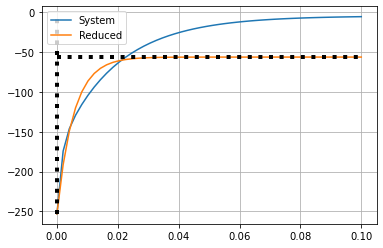

In [31]:
## Test model reduction
g,tau = tfProps(sys)
print(f'g = {g:.2f}, tau = {tau:.2f}')
sys1 = con.balred(sys,orders=1,method='truncate')
# print(con.dcgain(sys))
# print(con.dcgain(sys1))
con.tf(sys1)
g,tau = tfProps(sys1)
print(f'g = {g:.2f}, tau = {tau:.2f}')

t = np.linspace(0,0.1)
step = con.step_response(sys,T=t)
step1 = con.step_response(sys1,T=t)
plt.plot(t,step.outputs.T,label='System')
plt.plot(t,step1.outputs.T,label='Reduced')
plt.legend()
plt.grid()
plotLines()

In [32]:
print(Tau)


{'ADP': 0.014866156765752257, 'ATP': 0.01486615676575225, 'CO2': 0.00017684665624202378, 'G6P': 0.03004139008090118, 'NADP': 0.00017642871957648497, 'NADPH': 0.0013662874711383617, 'R5P': 0, 'G3P': 0}


## Compute reaction sensitivities

Doing: sPGI
kappa_PGI
g = -28.80991511396469 tau = 0
dlam = 10
G6P


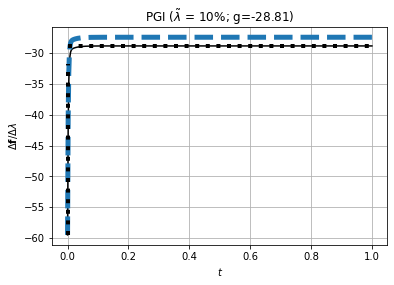

Doing: sPFK
kappa_PFK
g = -30.913609683373416 tau = 0.002278015825776077
dlam = 10
G6P


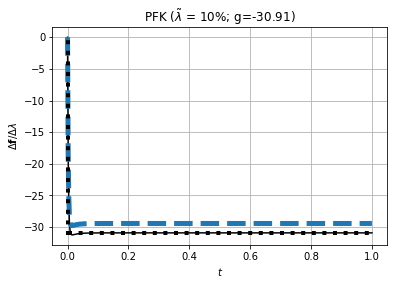

Doing: sFBA
kappa_FBA
g = -1.3427806651016105 tau = 0.026921154867136633
dlam = 10
G6P


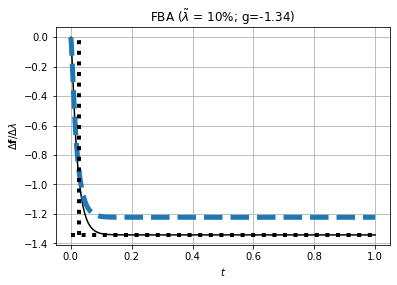

Doing: sTPI
kappa_TPI
g = -0.31124503089893363 tau = 0.03292616976551729
dlam = 10
G6P


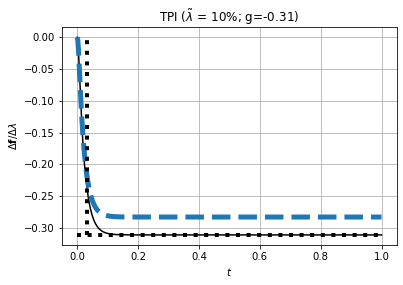

Doing: sG6PDH2R
kappa_G6PDH2R
g = -11.05834536093916 tau = 0
dlam = 10
G6P


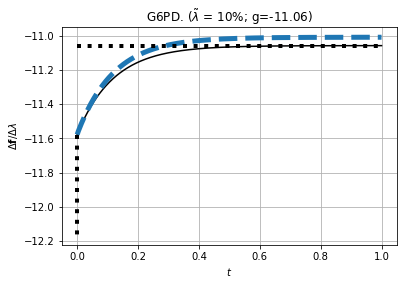

Doing: sPGL
kappa_PGL
g = -0.019168880963538627 tau = 0.016293783108219457
dlam = 10
G6P


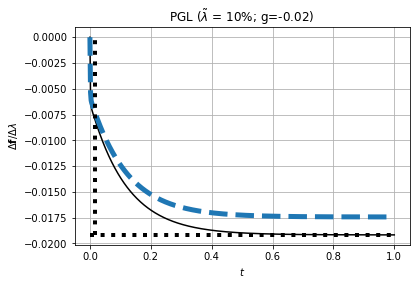

Doing: sGND
kappa_GND
g = -0.4958705310747634 tau = 0.12751609732062125
dlam = 10
G6P


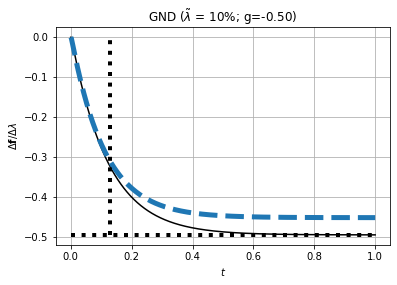

Doing: sRPI
kappa_RPI
g = -0.00339246977181743 tau = 0.00824443541241612
dlam = 10
G6P


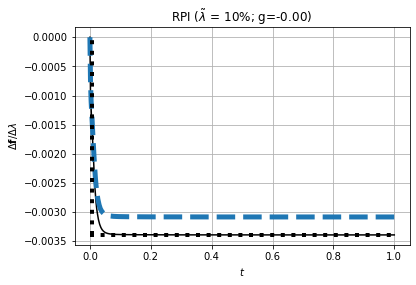

Doing: sTKT2
kappa_TKT2
g = 0.09778496614281532 tau = 0.0009111118563853957
dlam = 10
G6P


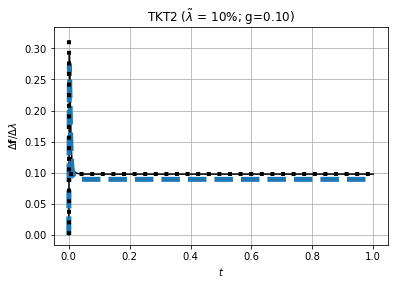

Doing: sTALA
kappa_TALA
g = 1.4213693479775253 tau = 0.0033987149739030348
dlam = 10
G6P


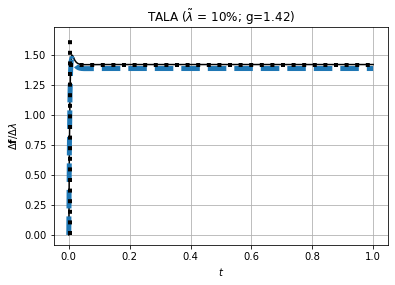

Doing: sTKT1
kappa_TKT1
g = 0.2669211003303768 tau = 0.021001174006396915
dlam = 10
G6P


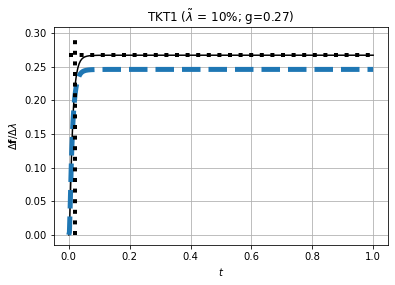

Doing: sRPE
kappa_RPE
g = 0.06664804356236037 tau = 0.008221010075271595
dlam = 10
G6P


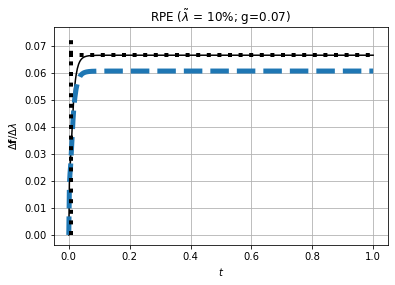

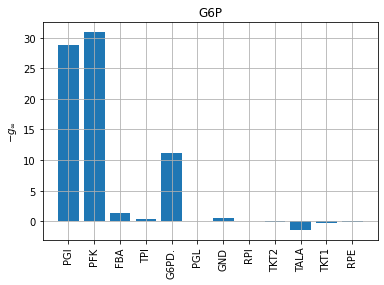

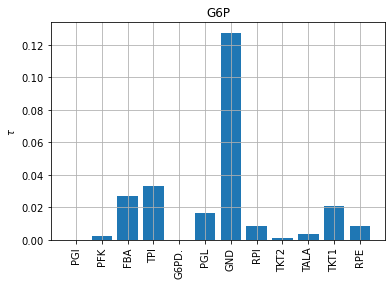

Doing: sPGI
kappa_PGI
g = 0.4208987417694914 tau = 0.001784019116768216
dlam = 10
R5P


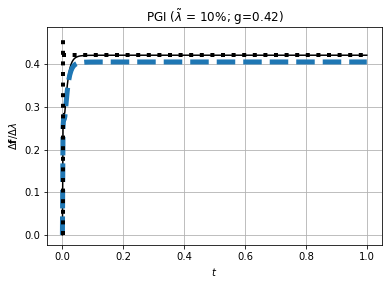

Doing: sPFK
kappa_PFK
g = -0.42364263563046833 tau = 0.001717964990211834
dlam = 10
R5P


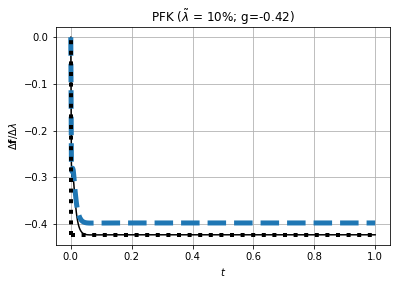

Doing: sFBA
kappa_FBA
g = -0.018401576065215863 tau = 0.033394801269318826
dlam = 10
R5P


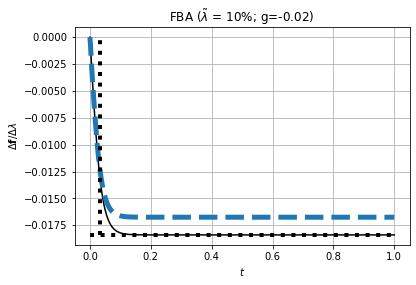

Doing: sTPI
kappa_TPI
g = -0.004265327359156856 tau = 0.039469568172793866
dlam = 10
R5P


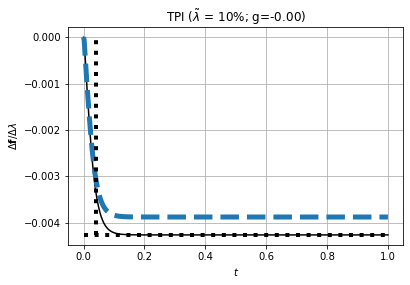

Doing: sG6PDH2R
kappa_G6PDH2R
g = 11.049474162931 tau = 0.12364579561293719
dlam = 10
R5P


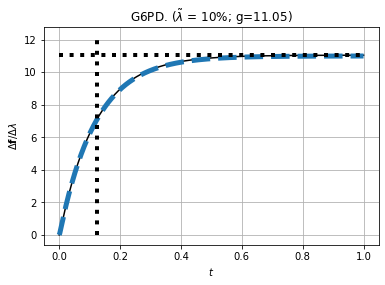

Doing: sPGL
kappa_PGL
g = 0.01915350335214014 tau = 0.0010470596032330958
dlam = 10
R5P


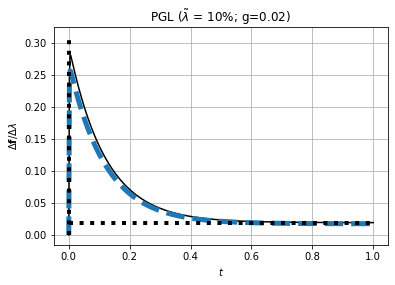

Doing: sGND
kappa_GND
g = 0.4954727350638917 tau = 2.6988194236854497e-06
dlam = 10
R5P


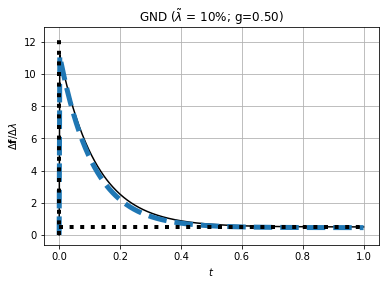

Doing: sRPI
kappa_RPI
g = 0.009795231203673538 tau = 0
dlam = 10
R5P


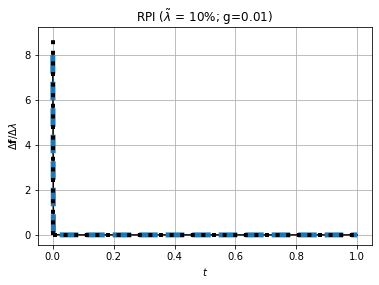

Doing: sTKT2
kappa_TKT2
g = -0.282924954852798 tau = 0.00017126550296392315
dlam = 10
R5P


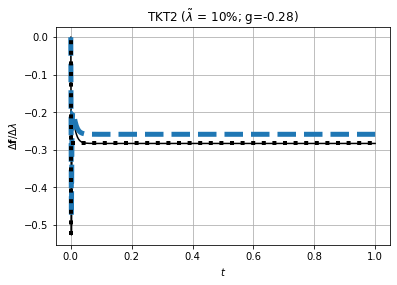

Doing: sTALA
kappa_TALA
g = -4.1125018954178 tau = 0.0045160996928807215
dlam = 10
R5P


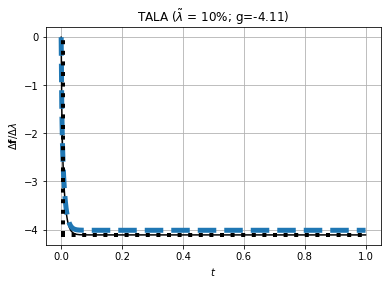

Doing: sTKT1
kappa_TKT1
g = -0.7722929529876414 tau = 0
dlam = 10
R5P


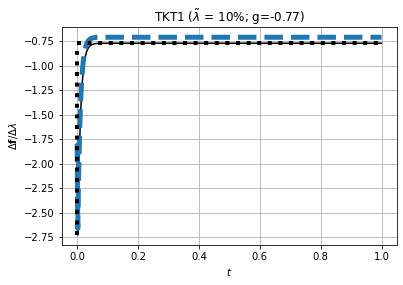

Doing: sRPE
kappa_RPE
g = -0.19283531466757647 tau = 2.6571744064148927e-06
dlam = 10
R5P


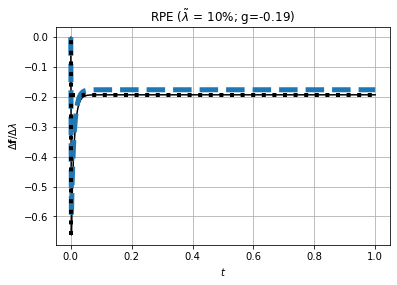

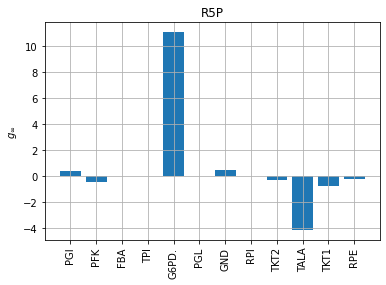

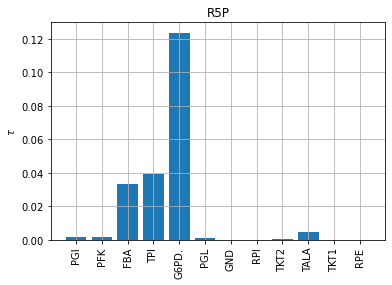

Doing: sPGI
kappa_PGI
g = -7.546999477333997e-07 tau = 0.0015271411542531847
dlam = 10
NADPH


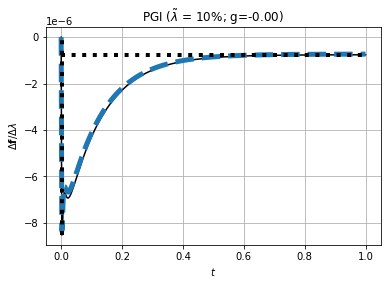

Doing: sPFK
kappa_PFK
g = 7.596199715986058e-07 tau = 0.0015261943288164277
dlam = 10
NADPH


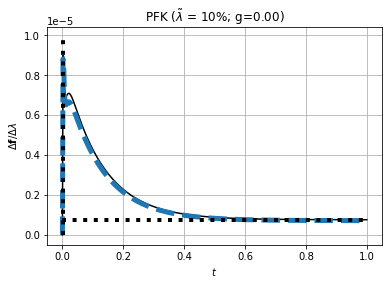

Doing: sFBA
kappa_FBA
g = 3.299527434456363e-08 tau = 0.019527507142779787
dlam = 10
NADPH


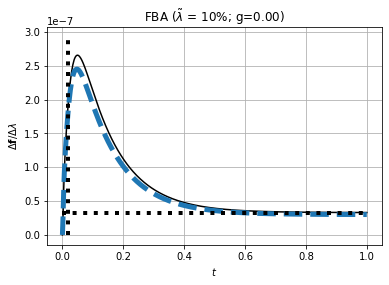

Doing: sTPI
kappa_TPI
g = 7.647982183374511e-09 tau = 0.02541572981821223
dlam = 10
NADPH


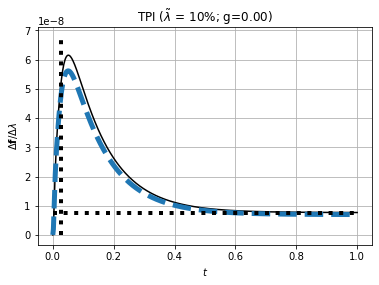

Doing: sG6PDH2R
kappa_G6PDH2R
g = 22.126061707076737 tau = 0
dlam = 10
NADPH


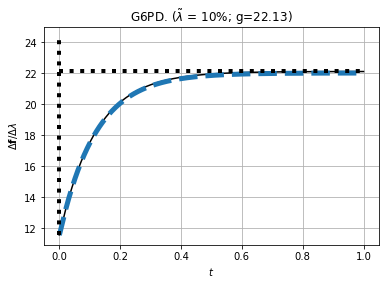

Doing: sPGL
kappa_PGL
g = 0.03835400588527368 tau = 0.001025533527882495
dlam = 10
NADPH


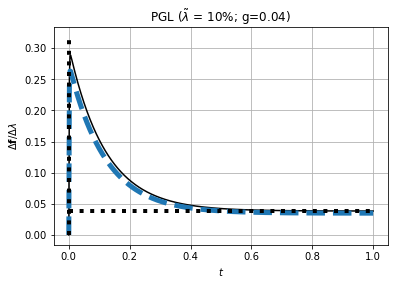

Doing: sGND
kappa_GND
g = 0.9921612692650577 tau = 0
dlam = 10
NADPH


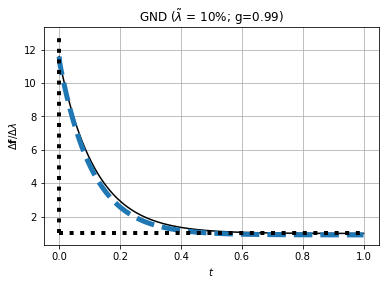

Doing: sRPI
kappa_RPI
g = 2.1458155641420664e-05 tau = 2.699186974424081e-06
dlam = 10
NADPH


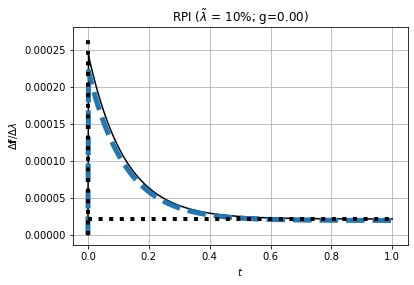

Doing: sTKT2
kappa_TKT2
g = 5.073036156607876e-07 tau = 0.00016943022110076314
dlam = 10
NADPH


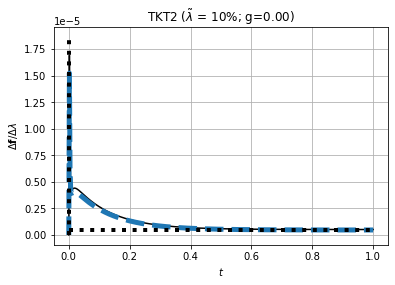

Doing: sTALA
kappa_TALA
g = 7.373994570839489e-06 tau = 0.0028552247467929955
dlam = 10
NADPH


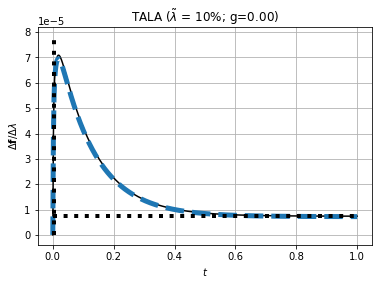

Doing: sTKT1
kappa_TKT1
g = 1.3847735970665945e-06 tau = 0.00018475667332612674
dlam = 10
NADPH


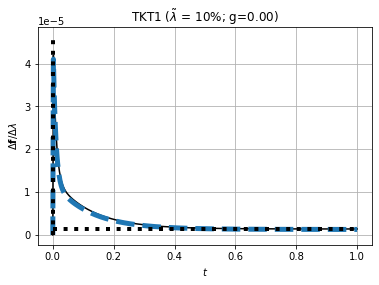

Doing: sRPE
kappa_RPE
g = 3.457667861388965e-07 tau = 2.6565945344600007e-06
dlam = 10
NADPH


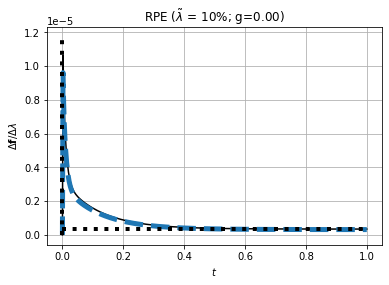

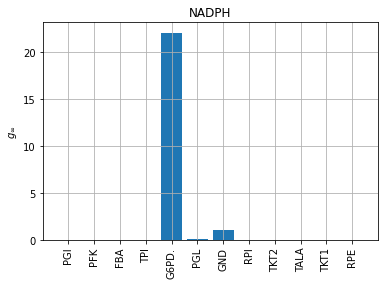

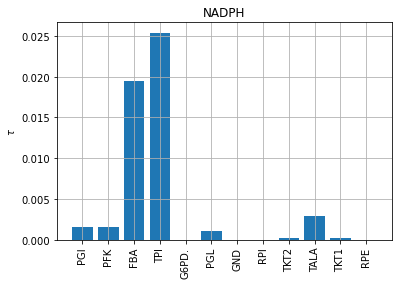

Doing: sPGI
kappa_PGI
g = 56.91833245076208 tau = 0.030041038107083886
dlam = 10
G3P


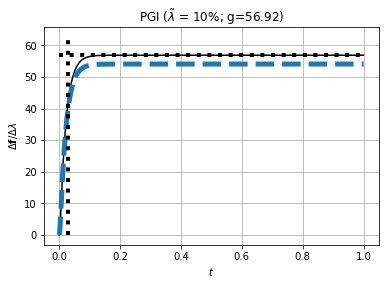

Doing: sPFK
kappa_PFK
g = 62.533290299526094 tau = 0.014866156765752257
dlam = 10
G3P


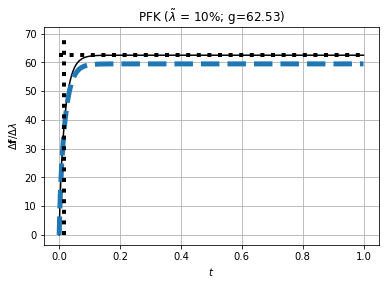

Doing: sFBA
kappa_FBA
g = 2.7162306181456373 tau = 0
dlam = 10
G3P


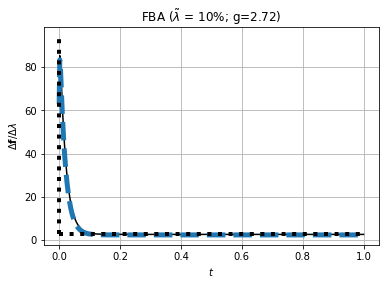

Doing: sTPI
kappa_TPI
g = 0.6295989394585817 tau = 0
dlam = 10
G3P


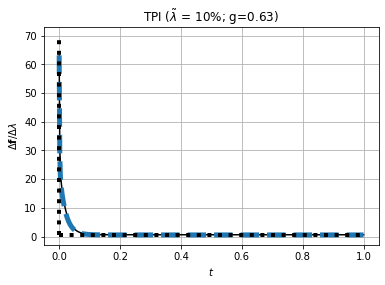

Doing: sG6PDH2R
kappa_G6PDH2R
g = 0.01322349914204985 tau = 0.12800864302389323
dlam = 10
G3P


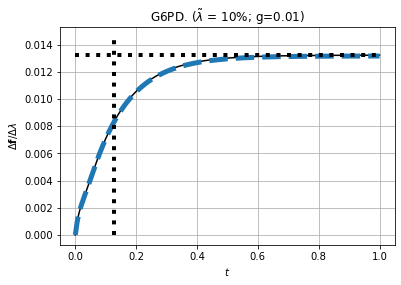

Doing: sPGL
kappa_PGL
g = 2.2922026197106206e-05 tau = 0.0014045237898896985
dlam = 10
G3P


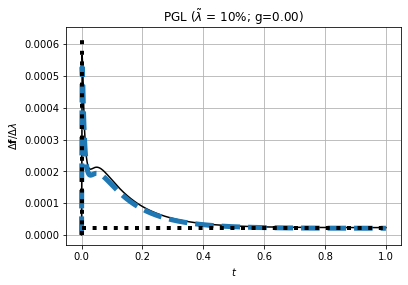

Doing: sGND
kappa_GND
g = 0.0005929588339176166 tau = 0.00017684665624202348
dlam = 10
G3P


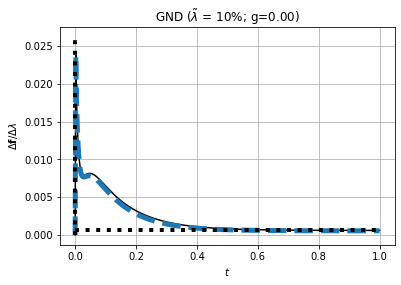

Doing: sRPI
kappa_RPI
g = -0.009544022155095424 tau = 0.00017769464683751047
dlam = 10
G3P


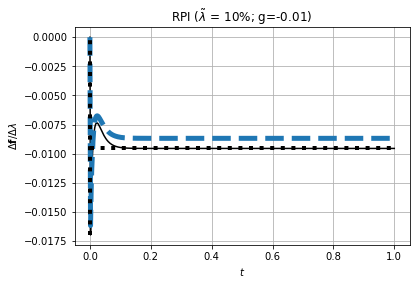

Doing: sTKT2
kappa_TKT2
g = 0.2759715745850926 tau = 0
dlam = 10
G3P


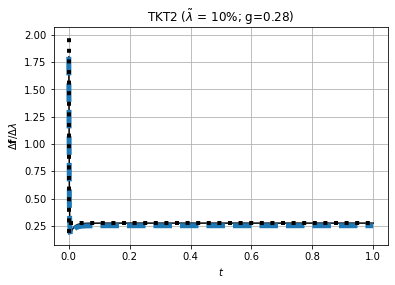

Doing: sTALA
kappa_TALA
g = 4.011429900742118 tau = 0
dlam = 10
G3P


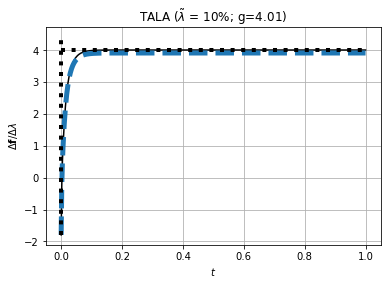

Doing: sTKT1
kappa_TKT1
g = 0.7533124901897006 tau = 0
dlam = 10
G3P


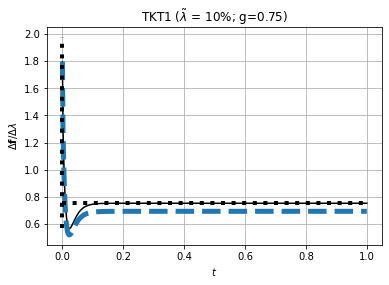

Doing: sRPE
kappa_RPE
g = 0.18809604636010738 tau = 0.00016682574714716445
dlam = 10
G3P


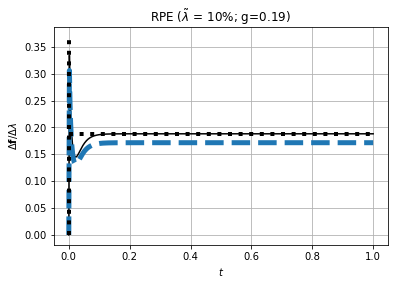

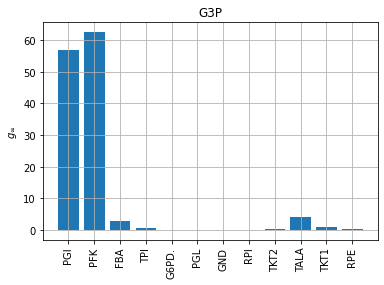

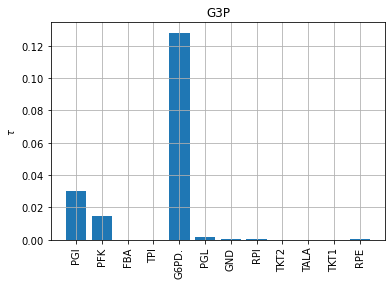

In [33]:
## Reaction sensitivities
Outp = ['G6P','R5P','NADPH','G3P']
Inp = []
for reac in s['reaction']:
    Inp.append('s'+reac)
    
Inp_reac = Inp
# Inp = []
# for reac in s['reaction']:
#     Inp.append('s'+reac)
# Inp = ['sG6PDH2R']

t_last=1
lam = 1.1 # Perturbation parameter

dcgain = {}
Tau = {}
for outp in Outp:
    for inp in Inp:
        print('Doing:',inp)
        sf = None
        order = None
        dat,y_step,t,sys = simSensitivity(s,sc,sf,Sys,X_ss,V_ss,dX_ss,chemostats=Chemostats,parameter=parameter,
                                      inp=[inp],outp=[outp],lam=lam,t_last=t_last,order=order,tol=None)

#         g = con.dcgain(sys)
        g,tau = tfProps(sys)
        print('g =',g, 'tau =',tau)
        poles = con.poles(sys)
#         print('Poles:', poles)
#         print('Zeros:', con.zeros(sys))
#         print(con.ss2tf(sys))
        name = inp[1:]
        if name == 'G6PDH2R':
            name = 'G6PD.'
        if outp=='G6P':
            dcgain[name] = -g
            ylabel = '$-g_{\infty}$'
        else:
            dcgain[name] = g
            ylabel = '$g_{\infty}$'
            
        Tau[name] = tau    
        
        dlam = int((lam-1)*100)
        print('dlam =',dlam)
        plt.title(f'Order = {poles.size}')
        if Titles:
            plt.title(f'{name}'+r' ($\tilde\lambda$ = ' + f'{dlam}%; g={g:.2f})')
        plotSensitivitydX(dat,species=[outp],labeling=False)
#         plt.hlines(g,min(t),max(t),color='black',ls='dashed')
        plotLines()
        Savefig('PPPdX_'+name+'_'+outp)

        plt.show()
        #print(con.tf(sys))


    ## Bar chart of gains
    if Titles:
        plt.title(outp)
    plt.tick_params(axis='x', rotation=90)
    plt.grid()
    plt.bar(range(len(dcgain)), dcgain.values(), align='center')
    plt.xticks(range(len(dcgain)), list(dcgain.keys()))
    plt.ylabel(ylabel)
    Savefig(f'PPPdX_{outp}_reac_bar')
    plt.show()
    
    ## Time constant
    if Titles:
        plt.title(outp)
    plt.tick_params(axis='x', rotation=90)
    plt.grid()
    plt.bar(range(len(Tau)), Tau.values(), align='center')
    plt.xticks(range(len(Tau)), list(Tau.keys()))
    plt.ylabel(r'$\tau$')
    Savefig(f'PPPdX_{outp}_reac_tau_bar')
    plt.show()

## Vary Lambda

kappa_G6PDH2R
G6PDH2R-R5P (DC gain: 11.049, HF gain = 0.000
kappa_G6PDH2R
G6PDH2R-R5P (DC gain: 11.049, HF gain = 0.000
R5P
kappa_G6PDH2R
G6PDH2R-R5P (DC gain: 11.049, HF gain = 0.000
R5P
kappa_G6PDH2R
G6PDH2R-R5P (DC gain: 11.049, HF gain = 0.000
R5P


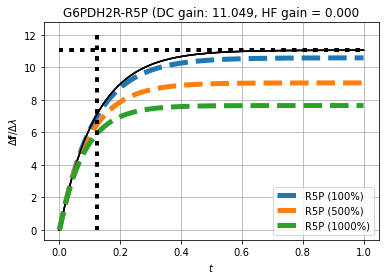

kappa_G6PDH2R
G6PDH2R-NADPH (DC gain: 22.126, HF gain = 11.578
kappa_G6PDH2R
G6PDH2R-NADPH (DC gain: 22.126, HF gain = 11.578
NADPH
kappa_G6PDH2R
G6PDH2R-NADPH (DC gain: 22.126, HF gain = 11.578
NADPH
kappa_G6PDH2R
G6PDH2R-NADPH (DC gain: 22.126, HF gain = 11.578
NADPH


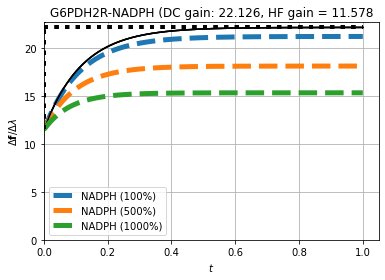

K_G6P
G6P-R5P (DC gain: 12.486, HF gain = 0.000
K_G6P
G6P-R5P (DC gain: 12.486, HF gain = 0.000
R5P
K_G6P
G6P-R5P (DC gain: 12.486, HF gain = 0.000
R5P
K_G6P
G6P-R5P (DC gain: 12.486, HF gain = 0.000
R5P


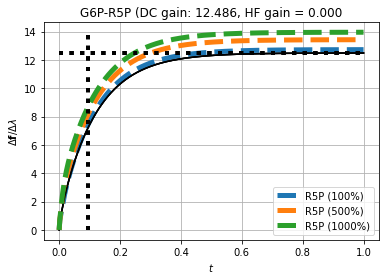

K_G6P
G6P-NADPH (DC gain: 23.170, HF gain = 12.125
K_G6P
G6P-NADPH (DC gain: 23.170, HF gain = 12.125
NADPH
K_G6P
G6P-NADPH (DC gain: 23.170, HF gain = 12.125
NADPH
K_G6P
G6P-NADPH (DC gain: 23.170, HF gain = 12.125
NADPH


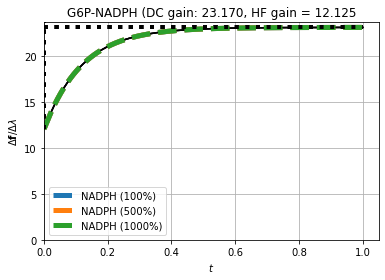

In [34]:
## Vary Lambda

# inp = 'sG6PDH2R'
# outp = ['R5P']
Lin = {}
Nlin = {} 
Lam = [1.1,2,6,11]
species = s['species']
for inp in ['sG6PDH2R','sG6P']:
    for outp in ['R5P','NADPH']:
        lin = []
        nlin = []
        for lam in Lam:
            dat,y_step,t,sys = simSensitivity(s,sc,sf,Sys,X_ss,V_ss,dX_ss,
                                              parameter=parameter,inp=[inp],outp=[outp],lam=lam,t_last=t_last)
#             g = con.dcgain(sys)
            g,tau = tfProps(sys)
            g_hf = hfgain(sys)
            
            lin.append(g)
            i = species.index(outp)
            dX = dat['dX'][-1,i]
            ng = (dX-dX_ss[i])/(lam-1)
            nlin.append(ng)
            
            name = inp[1:]
            Name = f'{name}-{outp}'
            print(f'{Name} (DC gain: {g:.3f}, HF gain = {g_hf:.3f}')
            if Titles:
                plt.title(f'{Name} (DC gain: {g:.3f}, HF gain = {g_hf:.3f}')
            if lam>1.5:
                setZero = outp in ['NADPH']
                plotSensitivitydX(dat,species=[outp],setZero=setZero)
                plotLines()
        Lin[Name] = lin  
        Nlin[Name] = nlin
        Savefig(f'PPPdX_{name}_{outp}_lambda')
        plt.show()
# print(Lin)
# print(Nlin)

G6PDH2R-R5P
G6PDH2R-NADPH
G6P-R5P
G6P-NADPH


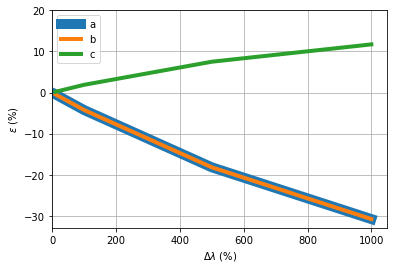

In [35]:
## Plot error curves
name = ['a','b','c','d']
lw = [10,4,4,4]
for i,Name in enumerate(Nlin):
    print(Name)
    G = np.array(Lin[Name])
    NG = np.array(Nlin[Name])
    Err = (NG-G)/G
    ErrPC = 100*Err
    LamPC = (Lam-np.ones(len(Lam)))*100
    
    ## Just plot the first 3
    if i<3:
        plt.plot(LamPC,ErrPC,label=name[i],lw=lw[i])
    
plt.legend()
plt.grid()
plt.ylim(top=20)
plt.xlim(left=0)
plt.xlabel(r'$\Delta \lambda$ (%)')
# plt.ylabel(r'$\tilde{\dot{x}}/\tilde{\lambda}-g$ (%)')
plt.ylabel(r'$\epsilon$ (%)')
Savefig(f'PPPdX_lambda')
plt.show()

# Sloppy parameter analysis


*******************************
 GlyPPP_PFK_2 
*******************************

H:
 [[ 5.23558279e+02 -3.97898795e+00]
 [-3.97898795e+00  1.76090966e-01]]
\sqrt\sigma_1 &= 23 & V_1\Lambda &= + 1.00 \lambda_{G6PDH2R} - 0.01 \lambda_{PFK}
\sqrt\sigma_2 &= 0.38 & V_2\Lambda &= + 1.00 \lambda_{PFK} + 0.01 \lambda_{G6PDH2R}
H_ss:
 [[ 6.12e+02 -4.68e+00]
 [-4.68e+00  1.79e-01]]
\sqrt\sigma_1 &= 25 & V_1\Lambda &= + 1.00 \lambda_{G6PDH2R} - 0.01 \lambda_{PFK}
\sqrt\sigma_2 &= 0.38 & V_2\Lambda &= + 1.00 \lambda_{PFK} + 0.01 \lambda_{G6PDH2R}


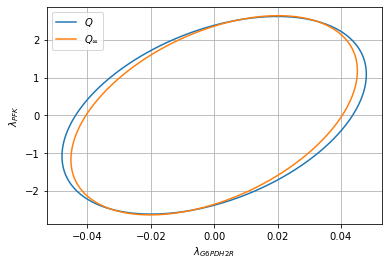

['ADP', 'ATP', 'CO2', 'G6P', 'H', 'H2O', 'NADP', 'NADPH', 'R5P', 'G3P']

*******************************
 GlyPPP_PFK_all 
*******************************

H:
 [[1726.16 1001.12]
 [1001.12 7677.69]]
\sqrt\sigma_1 &= 89 & V_1\Lambda &= + 0.99 \lambda_{PFK} + 0.16 \lambda_{G6PDH2R}
\sqrt\sigma_2 &= 40 & V_2\Lambda &= + 0.99 \lambda_{G6PDH2R} - 0.16 \lambda_{PFK}
H_ss:
 [[1958.04 1028.65]
 [1028.65 7785.82]]
\sqrt\sigma_1 &= 89 & V_1\Lambda &= + 0.99 \lambda_{PFK} + 0.17 \lambda_{G6PDH2R}
\sqrt\sigma_2 &= 42 & V_2\Lambda &= + 0.99 \lambda_{G6PDH2R} - 0.17 \lambda_{PFK}


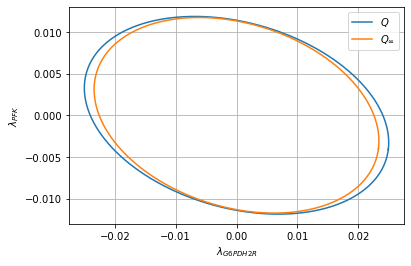


*******************************
 GlyPPP_PGI_all 
*******************************

H:
 [[1726.16  928.88]
 [ 928.88 6383.28]]
\sqrt\sigma_1 &= 81 & V_1\Lambda &= + 0.98 \lambda_{PGI} + 0.19 \lambda_{G6PDH2R}
\sqrt\sigma_2 &= 39 & V_2\Lambda &= + 0.98 \lambda_{G6PDH2R} - 0.19 \lambda_{PGI}
H_ss:
 [[1958.04  955.61]
 [ 955.61 6511.65]]
\sqrt\sigma_1 &= 82 & V_1\Lambda &= + 0.98 \lambda_{PGI} + 0.20 \lambda_{G6PDH2R}
\sqrt\sigma_2 &= 42 & V_2\Lambda &= + 0.98 \lambda_{G6PDH2R} - 0.20 \lambda_{PGI}


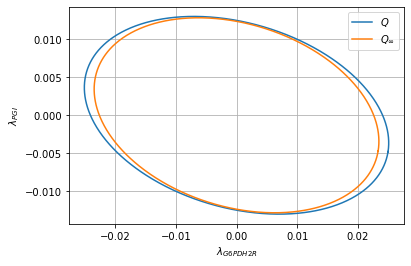


*******************************
 GlyPPP_PFK_2 
*******************************

H:
 [[ 6.02e+02 -4.60e+00]
 [-4.60e+00  1.78e-01]]
\sqrt\sigma_1 &= 25 & V_1\Lambda &= + 1.00 \lambda_{G6PDH2R} - 0.01 \lambda_{PFK}
\sqrt\sigma_2 &= 0.38 & V_2\Lambda &= + 1.00 \lambda_{PFK} + 0.01 \lambda_{G6PDH2R}
H_ss:
 [[ 6.12e+02 -4.68e+00]
 [-4.68e+00  1.79e-01]]
\sqrt\sigma_1 &= 25 & V_1\Lambda &= + 1.00 \lambda_{G6PDH2R} - 0.01 \lambda_{PFK}
\sqrt\sigma_2 &= 0.38 & V_2\Lambda &= + 1.00 \lambda_{PFK} + 0.01 \lambda_{G6PDH2R}


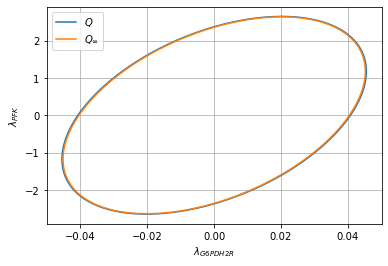

['ADP', 'ATP', 'CO2', 'G6P', 'H', 'H2O', 'NADP', 'NADPH', 'R5P', 'G3P']

*******************************
 GlyPPP_PFK_all 
*******************************

H:
 [[1930.92 1024.22]
 [1024.22 7827.07]]
\sqrt\sigma_1 &= 89 & V_1\Lambda &= + 0.99 \lambda_{PFK} + 0.17 \lambda_{G6PDH2R}
\sqrt\sigma_2 &= 42 & V_2\Lambda &= + 0.99 \lambda_{G6PDH2R} - 0.17 \lambda_{PFK}
H_ss:
 [[1958.04 1028.65]
 [1028.65 7785.82]]
\sqrt\sigma_1 &= 89 & V_1\Lambda &= + 0.99 \lambda_{PFK} + 0.17 \lambda_{G6PDH2R}
\sqrt\sigma_2 &= 42 & V_2\Lambda &= + 0.99 \lambda_{G6PDH2R} - 0.17 \lambda_{PFK}


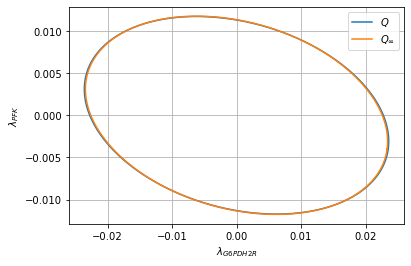


*******************************
 GlyPPP_PGI_all 
*******************************

H:
 [[1930.92  951.55]
 [ 951.55 6481.53]]
\sqrt\sigma_1 &= 82 & V_1\Lambda &= + 0.98 \lambda_{PGI} + 0.20 \lambda_{G6PDH2R}
\sqrt\sigma_2 &= 42 & V_2\Lambda &= + 0.98 \lambda_{G6PDH2R} - 0.20 \lambda_{PGI}
H_ss:
 [[1958.04  955.61]
 [ 955.61 6511.65]]
\sqrt\sigma_1 &= 82 & V_1\Lambda &= + 0.98 \lambda_{PGI} + 0.20 \lambda_{G6PDH2R}
\sqrt\sigma_2 &= 42 & V_2\Lambda &= + 0.98 \lambda_{G6PDH2R} - 0.20 \lambda_{PGI}


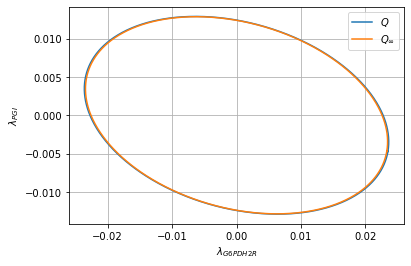

In [36]:
imp.reload(slp)
def sloppy(Sys,inp,outp,t=None):

    sys = extractSubsystem(Sys,sc,sf,inp,outp)
    #print(sys)
    H,eig,eigv,t = slp.Sloppy(sys,t=t)
    cond = np.linalg.cond(H)
    print(f'Log10 condition number: {np.log10(cond):.1f}')
    slp.SloppyPrint(eig,eigv,inp)
    slp.SloppyPlot(eig,eigv,inp,square=False)
    #slp.SloppyPlotData(t,y,inp,outp)
    
    
def sloppyBoth(Sys,inp,outp,t=None):
    
    sys = extractSubsystem(Sys,sc,sf,inp,outp)
    #SysName = sc['name']
    blurb = '\n*******************************\n'
    print(blurb,SysName,blurb)
    if t is None:
        name = f'{SysName}_sloppy_{inp[0]}'
    else:
        name = f'{SysName}_sloppy_{inp[0]}_long'
        
    #print(sys)
    H,eig,eigv,t = slp.Sloppy(sys,t=t,GainOnly=False)
    print('H:\n',H)
    slp.SloppyPrint(eig,eigv,inp,min_eig=0)
    H,Eig,Eigv,t = slp.Sloppy(sys,t=t,GainOnly=True)
    print('H_ss:\n',H)
    slp.SloppyPrint(Eig,Eigv,inp,min_eig=0)
    slp.SloppyPlot(eig,eigv,inp,Eig=Eig,Eigv=Eigv)
    
    Savefig(name) 
    plt.show()

    
for t_last in [0,1e1]:
    if t_last==0:
        t = None
    else:
        t = np.linspace(0,t_last,100)
        
    SysName = 'GlyPPP_PFK_2'
    inp = ['sG6PDH2R','sPFK']
    outp = ['NADPH','R5P']
    sloppyBoth(Sys,inp,outp,t=t)

    SysName = 'GlyPPP_PFK_all'
    Outp = []
    for chemo in sc['chemostats']:
        if not chemo[0] in ['s']:
            Outp.append(chemo)
    print(Outp)        
    sloppyBoth(Sys,inp,Outp,t=t)

    SysName = 'GlyPPP_PGI_all'
    inp = ['sG6PDH2R','sPGI']
    sloppyBoth(Sys,inp,Outp,t=t)



In [37]:
imp.reload(slp)
Outp = ['R5P','NADPH','G3P']
# Outp = ['R5P']
def PrintSloppy(Inp,Outp,GainOnly=True):
    blurb = '\n*********\n'
    for outp in Outp:
        print(blurb,outp,blurb)
        sys = extractSubsystem(Sys,sc,sf,Inp,[outp])
#         print(con.dcgain(sys))
        gain = con.dcgain(sys)[0]
        norm = np.sum(gain*gain)
        ngain = gain/np.sqrt(norm)
#         print(norm,gain/np.sqrt(norm))
        H,eig,eigv,t = slp.Sloppy(sys,GainOnly=GainOnly,small=1e-10)
        slp.SloppyPrint(eig,eigv,Inp,min_eig=0.01,min_eigv=0.1,max_eigs=5)
        if GainOnly:
            print('Direct')
            slp.SloppyPrint([norm],np.array([ngain]).T,Inp,min_eig=0.01,min_eigv=0.1,max_eigs=5)
#         print(eigv[:,0])
#         print(ngain)

## Reactions
for GainOnly in [True,False]:
    print('\nGainOnly =',GainOnly)
    PrintSloppy(Inp_reac,Outp,GainOnly=GainOnly)



GainOnly = True

*********
 R5P 
*********

\sqrt\sigma_1 &= 12 & V_1\Lambda &= + 0.93 \lambda_{G6PDH2R} - 0.35 \lambda_{TALA}
Direct
\sqrt\sigma_1 &= 12 & V_1\Lambda &= + 0.93 \lambda_{G6PDH2R} - 0.35 \lambda_{TALA}

*********
 NADPH 
*********

\sqrt\sigma_1 &= 22 & V_1\Lambda &= + 1.00 \lambda_{G6PDH2R}
Direct
\sqrt\sigma_1 &= 22 & V_1\Lambda &= + 1.00 \lambda_{G6PDH2R}

*********
 G3P 
*********

\sqrt\sigma_1 &= 85 & V_1\Lambda &= + 0.74 \lambda_{PFK} + 0.67 \lambda_{PGI}
Direct
\sqrt\sigma_1 &= 85 & V_1\Lambda &= + 0.74 \lambda_{PFK} + 0.67 \lambda_{PGI}

GainOnly = False

*********
 R5P 
*********

\sqrt\sigma_1 &= 11 & V_1\Lambda &= + 0.91 \lambda_{G6PDH2R} - 0.38 \lambda_{TALA} + 0.15 \lambda_{GND}
\sqrt\sigma_2 &= 3 & V_2\Lambda &= + 0.94 \lambda_{GND} - 0.25 \lambda_{G6PDH2R} - 0.21 \lambda_{TALA}

*********
 NADPH 
*********

\sqrt\sigma_1 &= 21 & V_1\Lambda &= + 0.99 \lambda_{G6PDH2R} + 0.11 \lambda_{GND}
\sqrt\sigma_2 &= 2.7 & V_2\Lambda &= + 0.99 \lambda_{GND} - 0.11 \l

In [38]:
## Chemostats
for GainOnly in [True,False]:
    print('\nGainOnly =',GainOnly)
    PrintSloppy(Inp_chemo,Outp,GainOnly=GainOnly)



GainOnly = True

*********
 R5P 
*********

\sqrt\sigma_1 &= 21 & V_1\Lambda &= + 0.59 \lambda_{G6P} + 0.57 \lambda_{NADP} - 0.56 \lambda_{R5P}
Direct
\sqrt\sigma_1 &= 21 & V_1\Lambda &= + 0.59 \lambda_{G6P} + 0.57 \lambda_{NADP} - 0.56 \lambda_{R5P}

*********
 NADPH 
*********

\sqrt\sigma_1 &= 34 & V_1\Lambda &= + 0.72 \lambda_{NADP} + 0.69 \lambda_{G6P}
Direct
\sqrt\sigma_1 &= 34 & V_1\Lambda &= + 0.72 \lambda_{NADP} + 0.69 \lambda_{G6P}

*********
 G3P 
*********

\sqrt\sigma_1 &= 1.4e+02 & V_1\Lambda &= + 0.87 \lambda_{G6P} + 0.48 \lambda_{ATP}
Direct
\sqrt\sigma_1 &= 1.4e+02 & V_1\Lambda &= + 0.87 \lambda_{G6P} + 0.48 \lambda_{ATP}

GainOnly = False

*********
 R5P 
*********

\sqrt\sigma_1 &= 1.5e+03 & V_1\Lambda &= + 1.00 \lambda_{R5P}

*********
 NADPH 
*********

\sqrt\sigma_1 &= 32 & V_1\Lambda &= + 0.74 \lambda_{NADP} + 0.67 \lambda_{G6P}

*********
 G3P 
*********

\sqrt\sigma_1 &= 1.3e+02 & V_1\Lambda &= + 0.86 \lambda_{G6P} + 0.48 \lambda_{ATP} - 0.16 \lambda_{G3P}
\sq

In [39]:
## Three outputs
Outp = ['R5P','NADPH','G3P']
sys = extractSubsystem(Sys,sc,sf,Inp,Outp)
for GainOnly in [True,False]:
    print('\nGainOnly =',GainOnly)
    H,eig,eigv,t = slp.Sloppy(sys,GainOnly=GainOnly,small=1e-10)
    slp.SloppyPrint(eig,eigv,Inp,min_eig=1e-3,min_eigv=0.1,max_eigs=4)


GainOnly = True
\sqrt\sigma_1 &= 85 & V_1\Lambda &= + 0.74 \lambda_{PFK} + 0.67 \lambda_{PGI}
\sqrt\sigma_2 &= 25 & V_2\Lambda &= + 1.00 \lambda_{G6PDH2R}
\sqrt\sigma_3 &= 3.8 & V_3\Lambda &= + 0.97 \lambda_{TALA} + 0.18 \lambda_{TKT1} - 0.14 \lambda_{PGI}

GainOnly = False
\sqrt\sigma_1 &= 83 & V_1\Lambda &= + 0.74 \lambda_{PFK} + 0.67 \lambda_{PGI}
\sqrt\sigma_2 &= 23 & V_2\Lambda &= + 0.99 \lambda_{G6PDH2R} + 0.12 \lambda_{GND}
\sqrt\sigma_3 &= 11 & V_3\Lambda &= + 0.95 \lambda_{FBA} + 0.29 \lambda_{TPI}
\sqrt\sigma_4 &= 4.3 & V_4\Lambda &= + 0.73 \lambda_{GND} - 0.64 \lambda_{TALA} - 0.14 \lambda_{G6PDH2R} - 0.14 \lambda_{TKT1}


In [40]:
## All outputs
for chemo in sc['chemostats']:
    if not chemo[0] in ['s']:
        Outp.append(chemo)
print(Outp)
sys = extractSubsystem(Sys,sc,sf,Inp,Outp)

for GainOnly in [True,False]:
    print('\nGainOnly =',GainOnly)
    H,eig,eigv,t = slp.Sloppy(sys,GainOnly=GainOnly,small=1e-10)
    slp.SloppyPrint(eig,eigv,Inp,min_eig=0.001,min_eigv=0.1,max_eigs=4)

['R5P', 'NADPH', 'G3P', 'ADP', 'ATP', 'CO2', 'G6P', 'H', 'H2O', 'NADP', 'NADPH', 'R5P', 'G3P']

GainOnly = True
\sqrt\sigma_1 &= 1.5e+02 & V_1\Lambda &= + 0.74 \lambda_{PFK} + 0.67 \lambda_{PGI}
\sqrt\sigma_2 &= 50 & V_2\Lambda &= + 0.99 \lambda_{G6PDH2R}
\sqrt\sigma_3 &= 6.3 & V_3\Lambda &= + 0.97 \lambda_{TALA} + 0.18 \lambda_{TKT1} - 0.13 \lambda_{PGI}

GainOnly = False
\sqrt\sigma_1 &= 1.5e+02 & V_1\Lambda &= + 0.74 \lambda_{PFK} + 0.67 \lambda_{PGI}
\sqrt\sigma_2 &= 47 & V_2\Lambda &= + 0.99 \lambda_{G6PDH2R} + 0.11 \lambda_{GND}
\sqrt\sigma_3 &= 16 & V_3\Lambda &= + 0.95 \lambda_{FBA} + 0.29 \lambda_{TPI}
\sqrt\sigma_4 &= 7.4 & V_4\Lambda &= + 0.92 \lambda_{GND} - 0.35 \lambda_{TALA} - 0.12 \lambda_{G6PDH2R}
